## Testing σ-irregularity vs. total σ-irregularity

### Problem Definition
We are given two measures of a graph irregularity,
*σ-irregularity* and *total σ-irregularity*, defined as bellow:<br /><br />
$$
\sigma(G) = \sum_{(u,v) \in E(G)}(d(u) - d(v))^2 
\quad\text{and}\quad 
\sigma_t(G) = \sum_{(u,v) \in V(G)}(d(u) - d(v))^2
$$.<br />
We are searching for graphs, where the ratio's
$r_{\sigma} = \sigma_t(G)\thinspace/\thinspace\sigma(G)$ 
maximum is reached.

### Basic Environment Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

from math import inf
import networkx as nx
import matplotlib.pyplot as plt

def setAxDefaults(ax, title, xlab, ylab):
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

class Bcol:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    GOLD = '\033[93m'
    FAIL = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC = '\033[0m'

NNODES = 40
NSIMUL = 200
NTESTS = 100

### Explicit Smaller Graph Optimums
For smaller graphs we will use the brute-force approach and test all the possibilites. We found an online database for all non-isomorphic, connected graphs on up to $11$ vertices, therefore this is what we will use, though the files for $10$ and $11$ vertices are too large so we will go up to $9$.

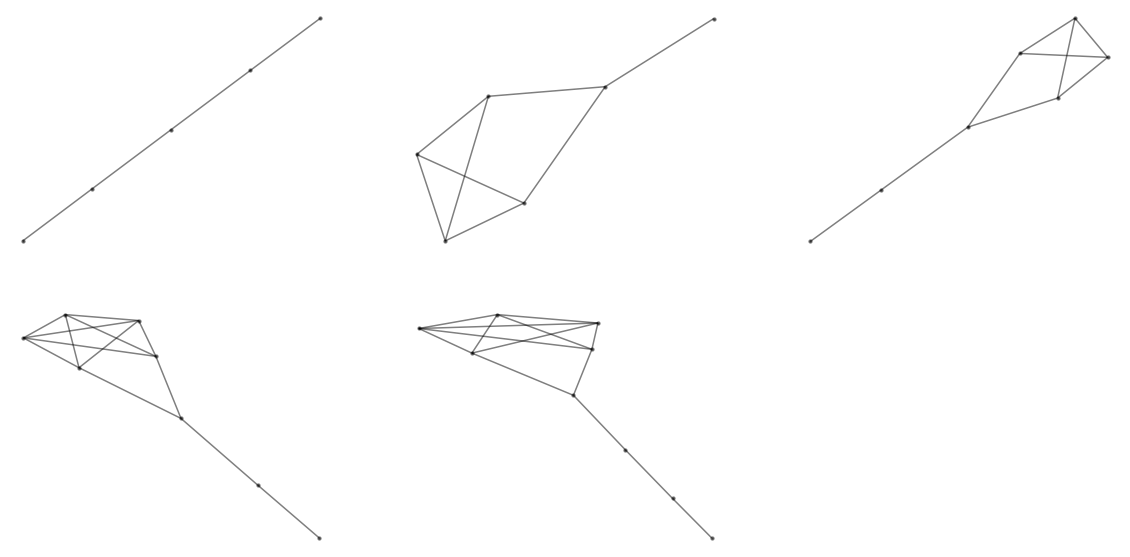

In [2]:
from pathlib import Path
from pylib import sigmaRatio_nx, simpleSubplot

files = Path().cwd() / 'g6data'
pairs = []
for file in files.iterdir():
    if file.suffix != '.g6': continue
    Gn = nx.read_graph6(file)
    pair = [0,0]
    for G in Gn:
        r = sigmaRatio_nx(G)
        if r > pair[0]:
            pair = [r, G]
    pairs.append(pair)
    
simpleSubplot(list(zip(*pairs))[1])

### Finding Larger Optimal Graphs

We will use simulated annealing algorithm to attack this problem and have written a library that will help us with the general implementation. 
The main idea was using the algorithm to find a global optimum (the graph that maximizes $\sigma_r$) by making global changes at every step and then fix the acquired graph by applying some mild local changes.

Lets try running the algorithm on 40 nodes with 200 simulations made and by choosing a *globalBasicNeighbor* topology, which defines the neighbor pretty much as a random connected graph on 40 vertices.

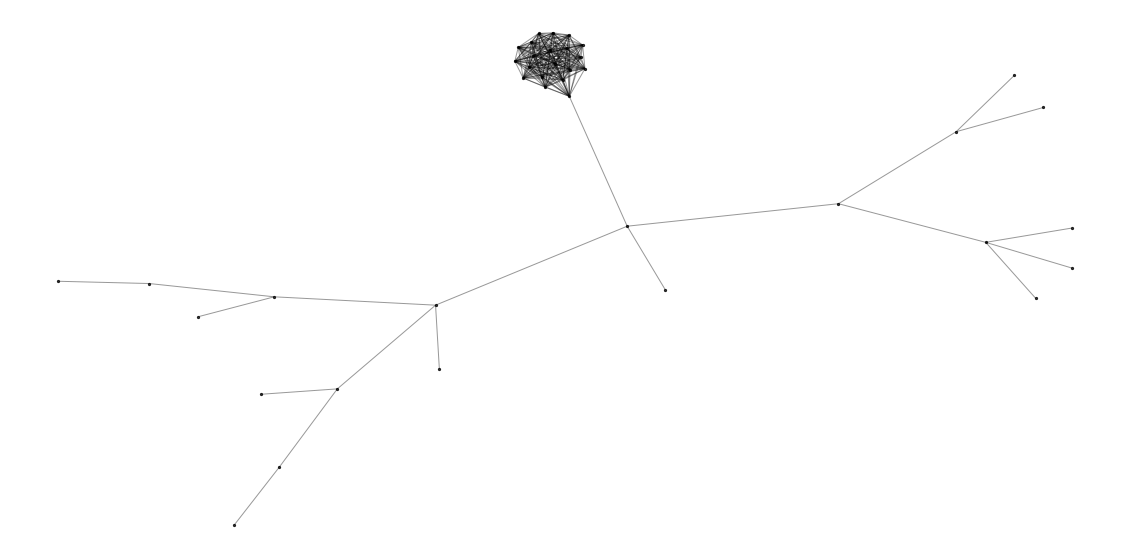

Sigma Ratio: 343.25581395348837


In [3]:
from pylib import (
    maxSigmaRatio_annealing, globalBasicNeighbor,
    simplePlot, neighborListToNx
)

g, r = maxSigmaRatio_annealing(
    40, 200, 200, globalBasicNeighbor
)

simplePlot(g)
print(Bcol.BLUE + 'Sigma Ratio:' + Bcol.ENDC, Bcol.GOLD + str(r) + Bcol.ENDC)

We noticed a pattern here early on, which is the two-parted nature of optimal graphs, so we adjusted the neighborhood topology for optimization purposes. Lets try out another topology.

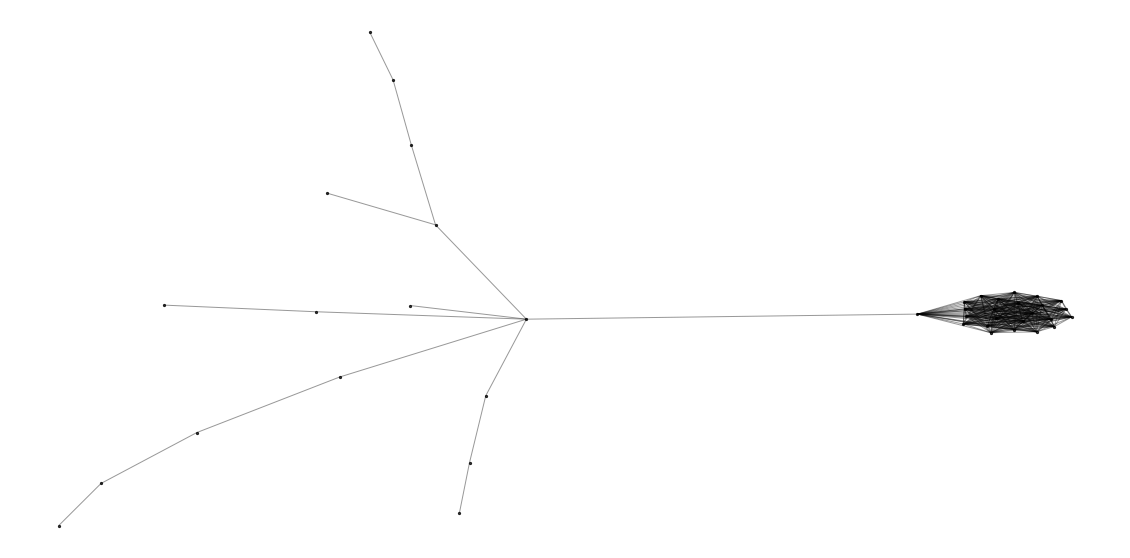

Sigma Ratio: 392.6575342465753


In [4]:
from pylib import globalTwoPartNeighbor

g, r = maxSigmaRatio_annealing(
    40, 100, 200, globalTwoPartNeighbor
)

simplePlot(g)
print(Bcol.BLUE + 'Sigma Ratio:' + Bcol.ENDC, Bcol.GOLD + str(r) + Bcol.ENDC)

Now we've covered the global part, but we still can find a slightly better optimum, by applying some local changes, like trying to smooth the difference between the degree of nodes forming a bridge between a full subgraph and the tree-like subgraph. This is implemented in the function *localBasicNeighbor*. Below we pass the previously acquired graph to be the default graph in the annealing search.

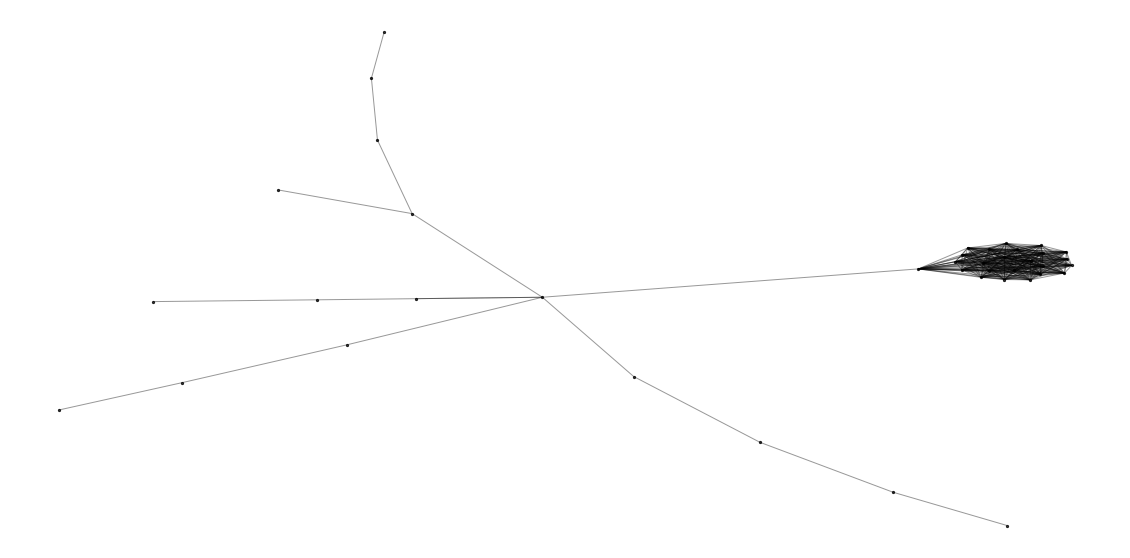

Sigma Ratio: 392.6575342465753


In [5]:
from pylib import localBasicNeighbor

g, r = maxSigmaRatio_annealing(
    40, 100, 200, localBasicNeighbor,
    defaultG = g
)

simplePlot(g)
print(Bcol.BLUE + 'Sigma Ratio:' + Bcol.ENDC, Bcol.GOLD + str(r) + Bcol.ENDC)

### Sigma Ratio Growth
The next step is to see how the optimal graph's $\sigma_r$ value grows when its order rises.
We will graph the resulting $\sigma_r$ values using *matplotlib* as we did before implicitly.
But first lets gather the data.

In [6]:
nsim_global, nsim_local = 200, 20
index, ascend = [], []
node_range = range(3, 40)
for i in node_range:
    startedges = i * (i - 1) // 2
    g, r = maxSigmaRatio_annealing(
        i, startedges, nsim_global,
        globalTwoPartNeighbor
    )
    g, r = maxSigmaRatio_annealing(
        i, startedges, nsim_local,
        localBasicNeighbor
    )
    ascend.append(r)

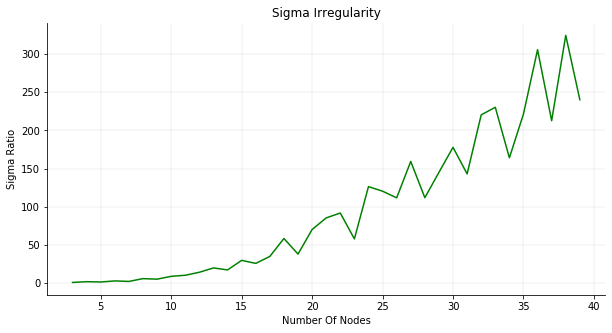

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
setAxDefaults(ax, 'Sigma Irregularity', 'Number Of Nodes', 'Sigma Ratio')
ax.plot(node_range, ascend, 'g')
plt.show()

We now have some sense of what is happening with the $\sigma_r$ values, but our task is also to find real values $c$ and $p$ for which $cn^p$ best aproximates $\sigma_r(G_n)$. 
We will implement this using the *smallest squares method*, which for given $p$ lets us find the best aproximation $c$ explicitly.

In [8]:
from pylib import squares

opt_diff, opt_c, opt_p = inf, 0, 0
for p in (i / 100 for i in range(400)):
    x = [pow(i, p) for i in node_range]
    c, d = squares(x, ascend)
    if d < opt_diff:
        opt_diff, opt_c, opt_p = d, c, p

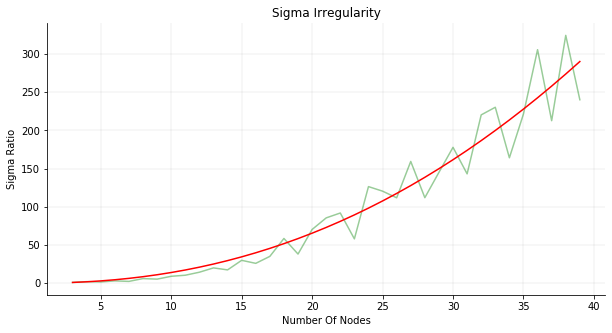

Optimal power: 2.23
Optimal constant: 0.08210459715613842
Optimal difference: 148.1681903655119


In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
setAxDefaults(ax, 'Sigma Irregularity', 'Number Of Nodes', 'Sigma Ratio')

ax.plot(node_range, ascend, 'g', alpha=0.4)
ax.plot(node_range, [opt_c * pow(i, opt_p) for i in node_range], 'r')
plt.show()

print(f'{Bcol.BLUE}Optimal power:{Bcol.ENDC}', Bcol.GREEN + str(opt_p) + Bcol.ENDC)
print(f'{Bcol.BLUE}Optimal constant:{Bcol.ENDC}', Bcol.GREEN + str(opt_c) + Bcol.ENDC)
print(f'{Bcol.BLUE}Optimal difference:{Bcol.ENDC}', Bcol.GREEN + str(opt_diff) + Bcol.ENDC)

For actual purposes we will read a file which we made after running SA algorithm on nodes up to 700.

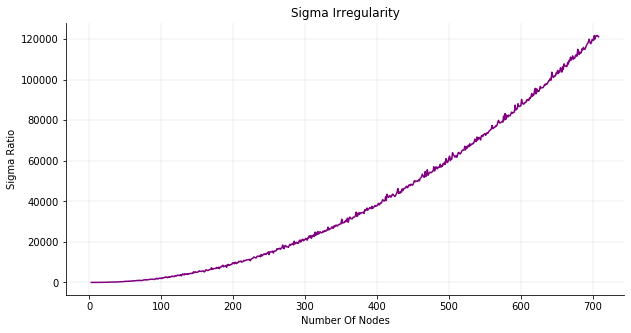

In [17]:
import json

with open('test_results/sigma_ratio_700.json', 'r') as file:
    sigma_ratio_results = json.load(file)
    
node_range = range(3, 3 + len(sigma_ratio_results))
fig, ax = plt.subplots(figsize=(10, 5))
setAxDefaults(ax, 'Sigma Irregularity', 'Number Of Nodes', 'Sigma Ratio')

ax.plot(node_range, sigma_ratio_results, 'purple')
plt.show()

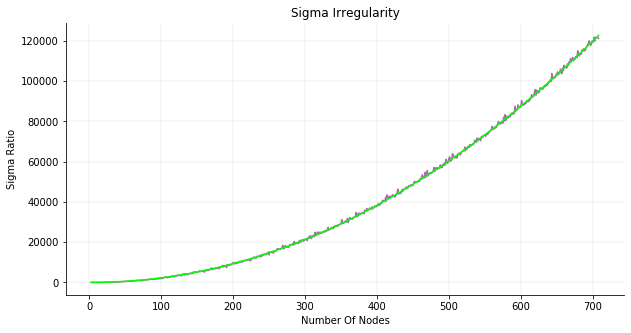

Optimal power: 2.037999999999965
Optimal constant: 0.19075292631871665
Optimal deviation: 603.986792148023


In [23]:
from pylib import powerAproximation

opt_diff, opt_c, opt_p = powerAproximation(sigma_ratio_results, 1, 4, 1000, node_range)
fig, ax = plt.subplots(figsize=(10, 5))
setAxDefaults(ax, 'Sigma Irregularity', 'Number Of Nodes', 'Sigma Ratio')

ax.plot(node_range, sigma_ratio_results, 'purple', alpha=0.6)
ax.plot(node_range, [opt_c * pow(i, opt_p) for i in node_range], 'lime')
plt.show()

print(f'{Bcol.BLUE}Optimal power:{Bcol.ENDC}', Bcol.GREEN + str(opt_p) + Bcol.ENDC)
print(f'{Bcol.BLUE}Optimal constant:{Bcol.ENDC}', Bcol.GREEN + str(opt_c) + Bcol.ENDC)
print(f'{Bcol.BLUE}Optimal deviation:{Bcol.ENDC}', Bcol.GREEN + str(opt_diff) + Bcol.ENDC)

After seeing this it really seems that the deviation is falling and the values get better aproximated by $n^2$.

### Neighbor Degree Conjecture
We are testing the conjecture, which says that for larger graphs every node is only adjacent to nodes with absolute degree difference smaller than $1$.
We will test this by counting the nodes, which do not meet the latter condition. 
We will also calculate the average degree difference of said nodes.

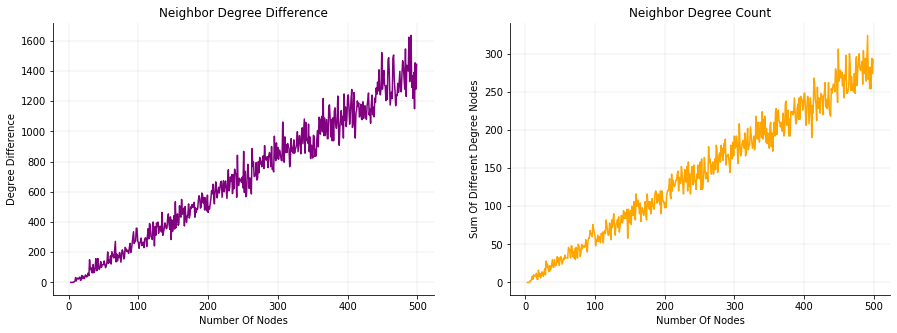

In [12]:
with open('test_results/degree_diff_500.json') as file:
    degree_diff = json.load(file)

count, deg_sum = list(zip(*degree_diff))
node_range = range(3, 3 + len(degree_diff))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
setAxDefaults(ax1, 'Neighbor Degree Difference', 'Number Of Nodes', 'Degree Difference')
setAxDefaults(ax2, 'Neighbor Degree Count', 'Number Of Nodes', 'Sum Of Different Degree Nodes')

ax1.plot(node_range, deg_sum, 'purple')
ax2.plot(node_range, count, 'orange')
plt.show()

This looks pretty linear, therefore we will try out some linear aproximation.

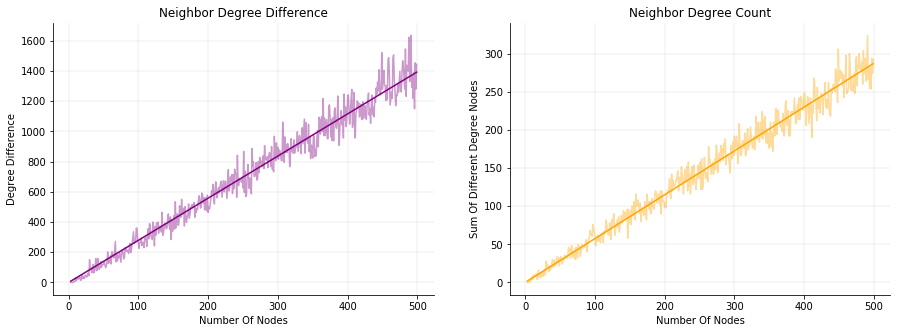

Degree difference constant: 2.7894615404336047			Count constant: 0.5748786913019662


In [13]:
linear_count_const, _ = squares(list(node_range), count)
linear_deg_sum_const, _ = squares(list(node_range), deg_sum)

linear_count = [n * linear_count_const for n in node_range]
linear_deg_sum = [n * linear_deg_sum_const for n in node_range]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
setAxDefaults(ax1, 'Neighbor Degree Difference', 'Number Of Nodes', 'Degree Difference')
setAxDefaults(ax2, 'Neighbor Degree Count', 'Number Of Nodes', 'Sum Of Different Degree Nodes')

ax1.plot(node_range, deg_sum, 'purple', alpha=0.4)
ax2.plot(node_range, count, 'orange', alpha=0.4)
ax1.plot(node_range, linear_deg_sum, 'purple')
ax2.plot(node_range, linear_count, 'orange')
plt.show()

print(
    f'{Bcol.BLUE}Degree difference constant:{Bcol.ENDC}', 
    Bcol.GREEN + str(linear_deg_sum_const) + Bcol.ENDC, 
    end='\t\t\t'
)
print(
    f'{Bcol.BLUE}Count constant:{Bcol.ENDC}', 
    Bcol.GREEN + str(linear_count_const) + Bcol.ENDC
)

### Node Degree Distribution
We will look at how the degrees are distributed on optimal graphs.

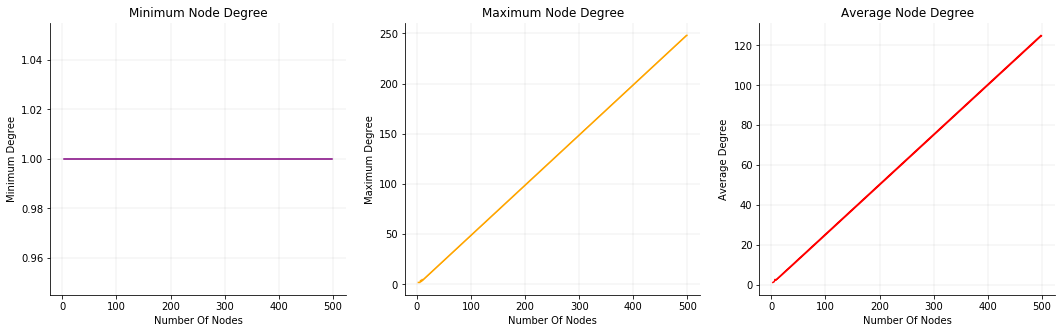

In [14]:
with open('test_results/degree_distribution_500.json') as file:
    deg_distrib = json.load(file)

mn, mx, avg = list(zip(*deg_distrib))
node_range = range(3, 3 + len(deg_distrib))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
setAxDefaults(ax1, 'Minimum Node Degree', 'Number Of Nodes', 'Minimum Degree')
setAxDefaults(ax2, 'Maximum Node Degree', 'Number Of Nodes', 'Maximum Degree')
setAxDefaults(ax3, 'Average Node Degree', 'Number Of Nodes', 'Average Degree')

ax1.plot(node_range, mn, 'purple')
ax2.plot(node_range, mx, 'orange')
ax3.plot(node_range, avg, 'red')
plt.show()